# Multi-level Analysis of E-Bike Sharing Demand in London: 
# Assessing the Impact of Weather and Temporal Factors

# 1.INTRODUCTION

The rapid urbanization has led to challenges in traditional transportation, such as traffic congestion and air pollution(Smith and Lee, 2021). Bike-sharing systems have emerged as a sustainable and globally popular solution, reshaping urban transit dynamics(Johnson, 2022).

In London, the demand for healthier lifestyles and concerns over traffic congestion have facilitated the adoption of e-bike sharing syste(Bennett and Patel, 2023)s. The government and stakeholders have embraced these initiatives to mitigate urban traffic, reduce emissions, and enhance quality of life.

This research project aims to analyze how weather conditions and times of the day influence the utilization of London's e-bike sharing service. By examining usage data, the study seeks to uncover user patterns and needs. Insights from this analysis will contribute to refining transportation resource management and informing future urban mobility planning.s.

# 2. Literature Review

Recent studies have applied innovative data-driven approaches to forecast and optimize bike-sharing demand in London. Rylander et al. (2023) combined K-means clustering for geographical segmentation with polynomial regression to predict shared bike demand, showing that precise demand forecasting can enhance bike distribution and improve operational efficiency and customer satisfaction. Heydari et al. (2023) implemented a generalized negative binomial regression model to analyze the influence of meteorological and non-meteorological factors on daily bike rental demand, emphasizing the importance of integrating economic and climatic predictability into policy-making.

Drawing from these methodologies, this project proposes to utilize weather conditions and temporal variables as primary analytical features. Through visual analytics and a decision tree model, this study aims to project shared bike demand in London, assisting urban planners, policy makers, and bike-sharing operators in refining service operations and enhancing user experience.

Recent advancements in deep learning, particularly Long Short-Term Memory (LSTM) networks, have shown promising results in bike-sharing demand forecasting due to their ability to capture long-term dependencies and temporal patterns (Hochreiter & Schmidhuber, 1997). By incorporating LSTM alongside other machine learning techniques, this project aims to provide a comprehensive framework for predicting bike-sharing demand in London, contributing to a more accurate and reliable demand forecasting system.

# 3.Research Question

1. Investigating the impact of weather conditions and temporal factors on the demand for e-bike sharing in London

2. Developing a predictive model for e-bike sharing demand using machine learning techniques(compare 4 techniques)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 4.Data Description

This dataset spans from January 4th, 2015 to January 3rd, 2017 and encapsulates total bike hire numbers from a bike rental scheme in London. 

- `timestamp`: A timestamp field utilized for aggregating the data.
- `cnt`: The count of new bike shares initiated within the timestamp.
- `t1`: Ambient air temperature in degrees Celsius.
- `t2`: 'Feels like' temperature in degrees Celsius, accounting for the effects of wind and humidity.
- `hum`: Relative humidity expressed as a percentage.
- `windspeed`: Wind speed measured in kilometers per hour.
- `weathercode`: A categorical variable representing the weather condition during the timestamp, with categories as follows:
  - 1: Clear c hich ma of s of fogttered or few clouds.
  - 3: Broken clouds.
  - 4: Cloudy.d light rTcompanied by thunderstorms.
  - 26: Snowfall.Bool,icating whether the day is a bank holiday (1) or not (0).Bool,dicating whether the day falls on a weekend (1) or a working day (0).
- `season`: A categorical variable indicating the meteorological season (0: Spring, 1: Summer, 2: Autumn, 3: Winter).

From the `timestamp` variable, a multitude of temporal featu. bike hire patterns.

In [3]:
data_frame = pd.read_csv(r"london_merged.csv")
data_frame.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
def encode_data(df):
    # create
    encoded_df = df.copy()
    
    # 处理数值型特征
    numeric_features = ['cnt', 't1', 't2', 'hum', 'wind_speed', 'hour_of_day', 'day_of_month', 'month', 'year', 'week_of_year', 'day_of_week']
    encoded_df[numeric_features] = encoded_df[numeric_features].apply(pd.to_numeric)
    
    # 处理布尔型特征
    boolean_features = ['is_holiday', 'is_weekend']
    encoded_df[boolean_features] = encoded_df[boolean_features].astype(int)
    
    # 对类别型特征进行独热编码
    categorical_features = ['weather_code', 'season']
    encoded_df = pd.get_dummies(encoded_df, columns=categorical_features, prefix=categorical_features)
    
    return encoded_df

# 调用函数进行编码
encoded_data = encode_data(data_frame)

### Data Preparation and Encoding

For the application of numerical models, it is imperative that all input data be represented in numerical or Boolean formats. Non-numeric variables must be transformed accordingly, either into continuous numeric types, which imply a proportional relationship, or into binary Boolean types, where values are represented as 1 (True) or 0 (False).

#### Numeric Transformation
Transforming variables into numeric formats may suggest a linear relationship, such as the day of the month being encoded directly by its numeral value.

**Numeric Features**: 
- Direct Measures: `cnt`, `t1` (temperature), `t2` (feels-like temperature), `hum` (humidity), `wind_speed`.
- Engineered Time Features: `hour`, `day_of_month`, `month_number`, `year`, `week_number`, `day_of_week`.
- Other: `season` (could also be categorized), `periods_from_start` (time since start of dataset).

#### Categorical Transformation
For categorical variables, encoding is necessary to convert them into a machine-readable format.

**Categorical Features**:
- Boolean Variables: `is_holiday`, `is_weekend`, `is_schoolholiday`, `is_daylight?` (each coded as 1 or 0).
- One-Hot Encoded Variables:
  - `weather_code`: Transformed into multiple binary columns, each representing a distinct weather condition.
  - `season`: Optionally, instead of treating as numeric, it can be one-hot encoded to represent the four seasons as separate binary variables.
  - `day_of_week`: Alternatively, it can be one-hot encoded to represent each day as a separate binary variable, which may capture weekly cycles more effectively.

In [4]:
print(data_frame.isnull().sum())

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64


# 5.Modelling process

## Feature Engineering

In [5]:
def create_features(df):
    new_df = df.copy()
    new_df["timestamp"] = pd.to_datetime(new_df["timestamp"])
    
    new_df["month"] = new_df["timestamp"].dt.month
    new_df["day_of_week"] = new_df["timestamp"].dt.dayofweek
    new_df["hour_of_day"] = new_df["timestamp"].dt.hour
    new_df["quarter"] = new_df["timestamp"].dt.quarter
    new_df["year"] = new_df["timestamp"].dt.year
    new_df["day_of_month"] = new_df["timestamp"].dt.day
    new_df["week_of_year"] = new_df["timestamp"].dt.isocalendar().week
    
    return new_df

In [6]:
data = create_features(data_frame)
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,day_of_week,hour_of_day,quarter,year,day_of_month,week_of_year
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,6,0,1,2015,4,1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,1,1,2015,4,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,6,2,1,2015,4,1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,6,3,1,2015,4,1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,6,4,1,2015,4,1


In [7]:
data.drop(labels = ["timestamp"], inplace = True, axis = 1)
data.rename(columns={"cnt": "demand", "hum": "humidity"}, inplace = True)
data.head()

,demand,t1,t2,humidity,wind_speed,weather_code,is_holiday,is_weekend,season,month,day_of_week,hour_of_day,quarter,year,day_of_month,week_of_year
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,6,0,1,2015,4,1
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,1,1,2015,4,1
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,6,2,1,2015,4,1
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,6,3,1,2015,4,1
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,6,4,1,2015,4,1


# Data vizualization

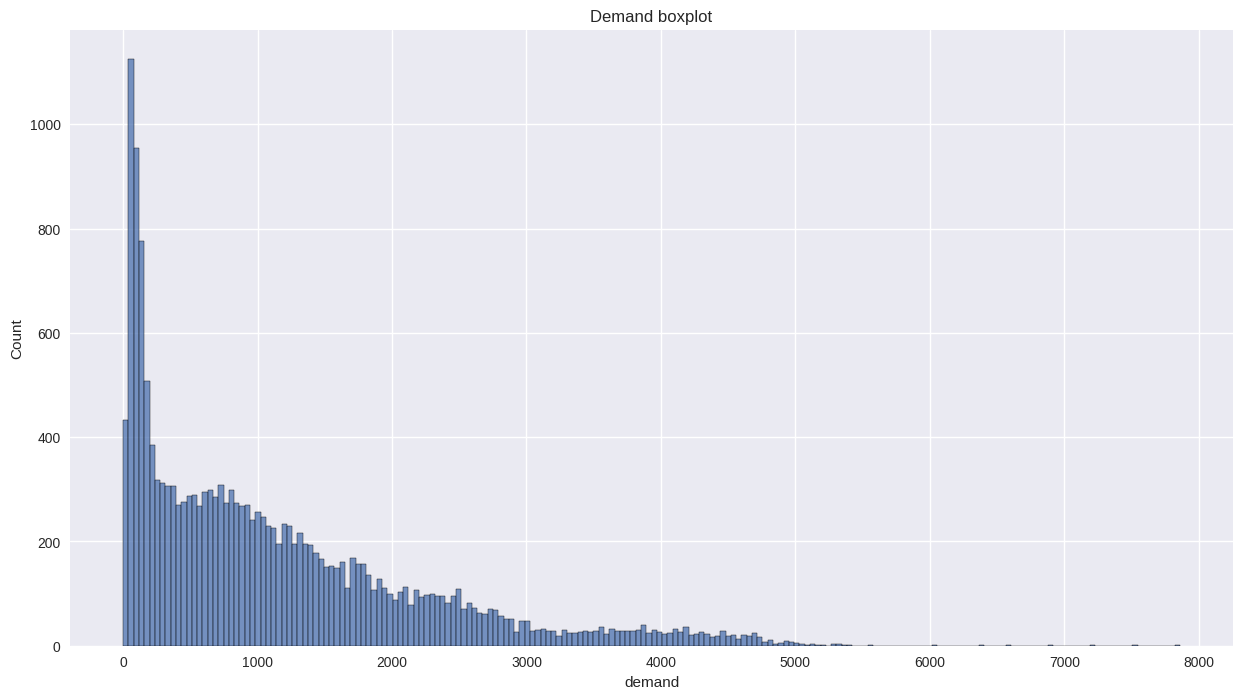

In [8]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.histplot(data = data, x = "demand", bins = 200).set(title = "Demand boxplot")
plt.show()

This plot illustrates the average hourly demand for rental bicycles throughout the day.  There is a clear bimodal distribution, with demand peaking during the morning and evening rush hours around 8am and 5pm respectively.  Demand is lowest in the early morning hours between midnight and 5am when most people are asleep.  The plot effectively captures the cyclical daily usage patterns driven by commuting behaviors.

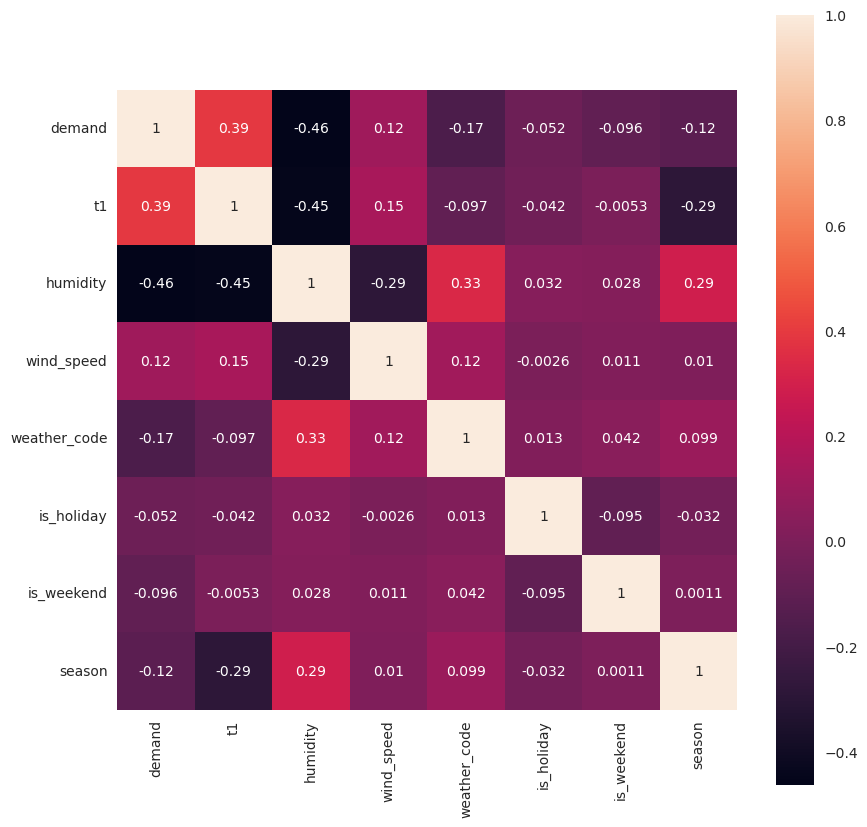

In [57]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data.corr(), annot = True, square = True)
plt.show()

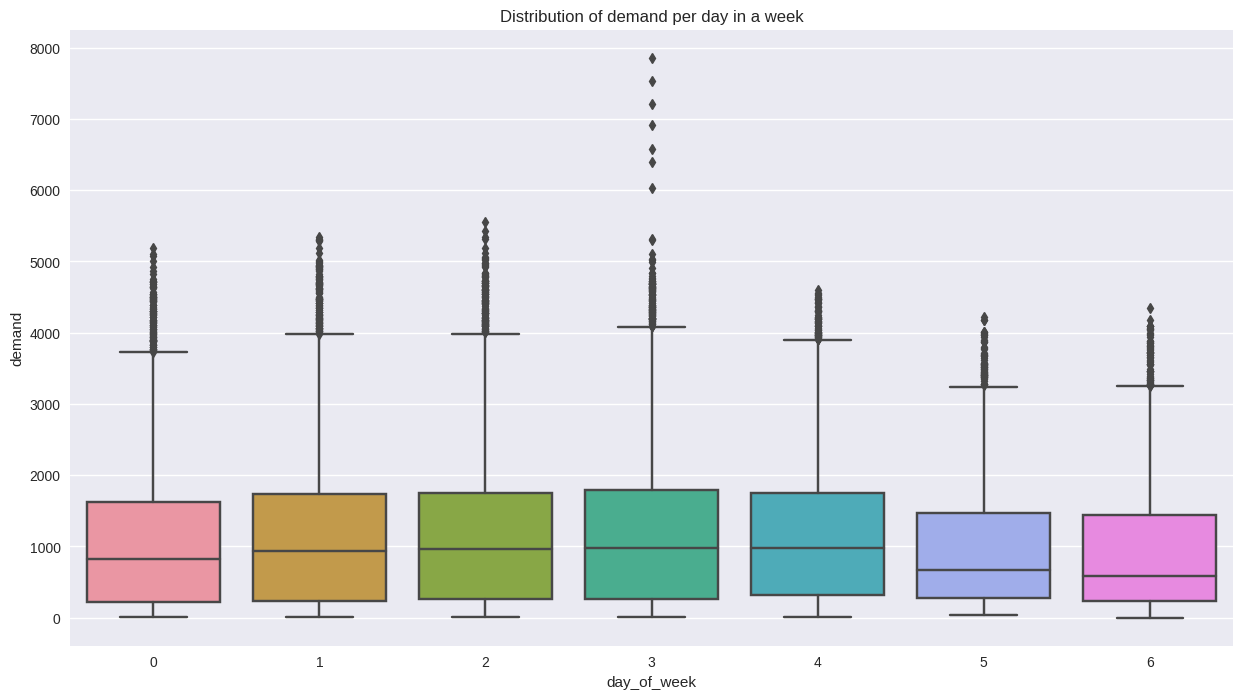

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='day_of_week', y='demand')
ax.set_title('Distribution of demand per day in a week')
plt.show()

Examining bicycle rental demand segmented by day of the week reveals some interesting patterns.  Weekdays (Monday through Friday) exhibit relatively similar demand levels, with slight dips on Mondays and Fridays.  However, demand noticeably decreases on weekends, especially Sundays.  This suggests that a significant portion of bike rentals is tied to weekday commuting and business activities rather than leisurely weekend rides.


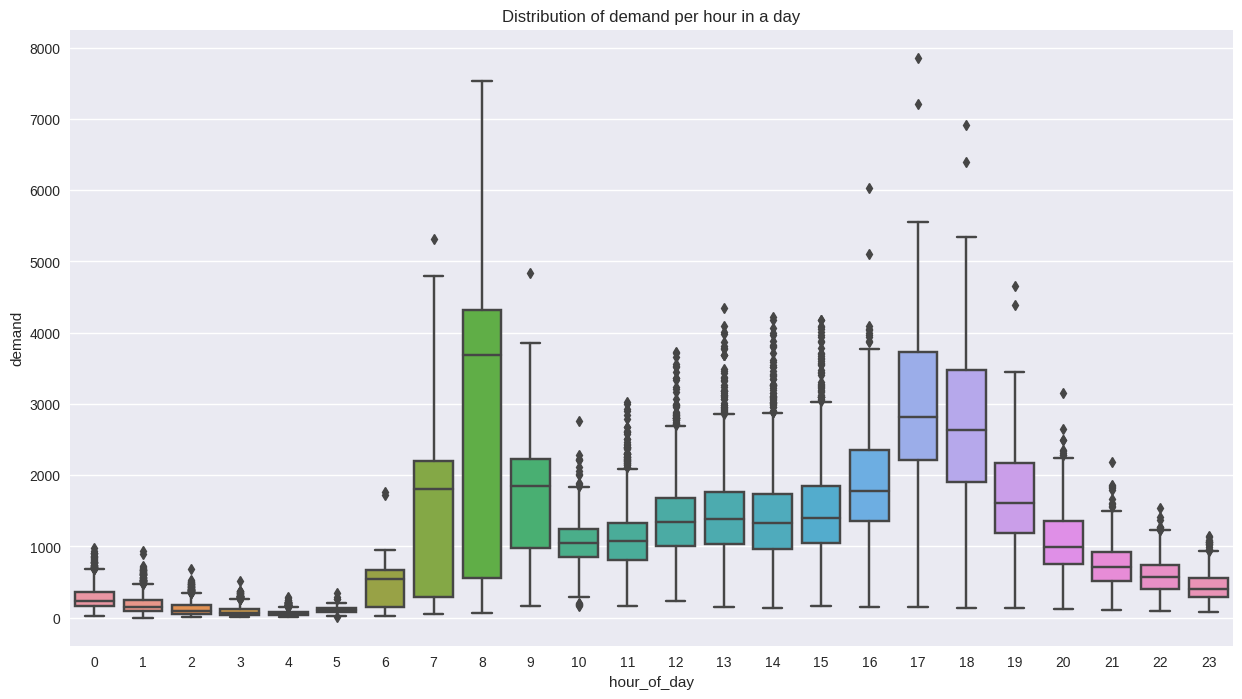

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='hour_of_day', y='demand')
ax.set_title('Distribution of demand per hour in a day')
plt.show()

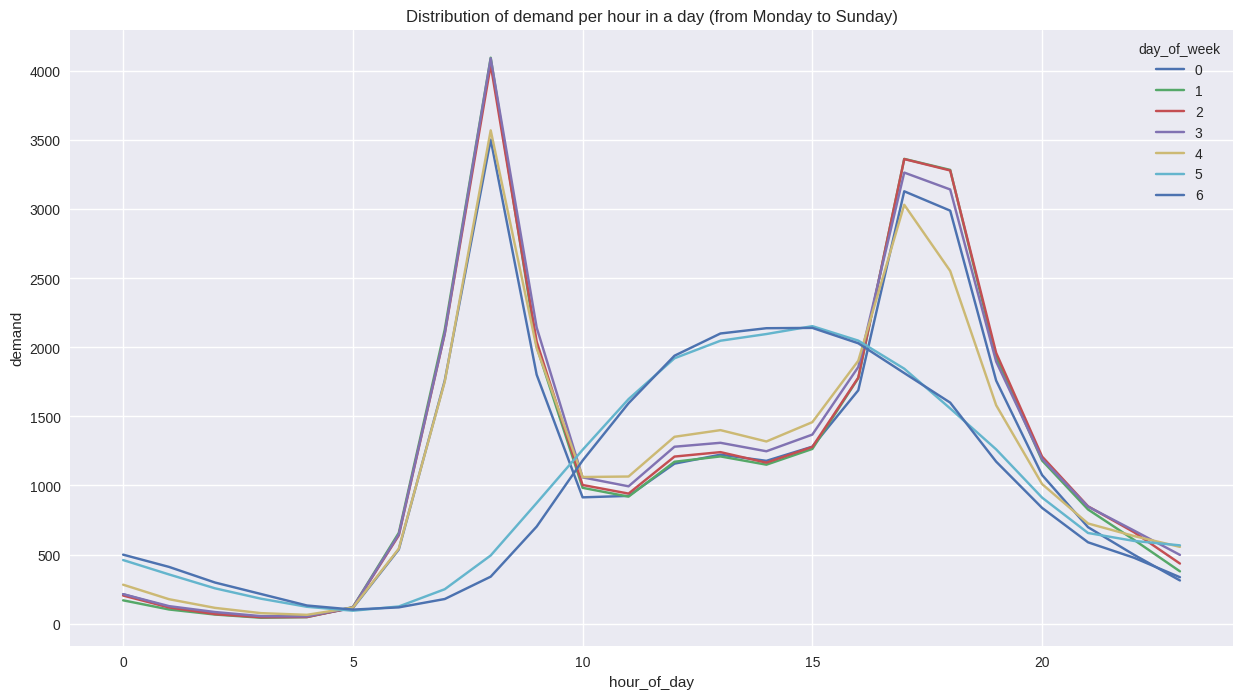

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=data, x='hour_of_day', y='demand', hue = "day_of_week", palette = sns.color_palette(), errorbar = None)
ax.set_title('Distribution of demand per hour in a day (from Monday to Sunday)')
plt.show()

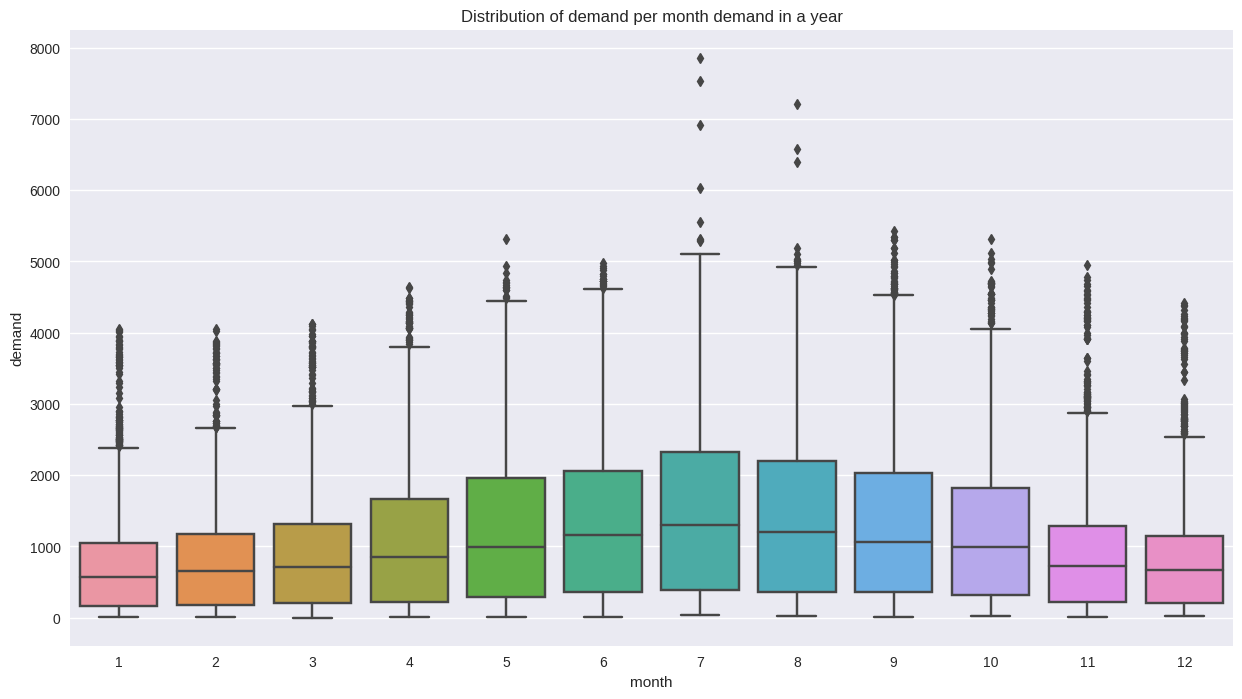

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='month', y='demand')
ax.set_title('Distribution of demand per month demand in a year')
plt.show()

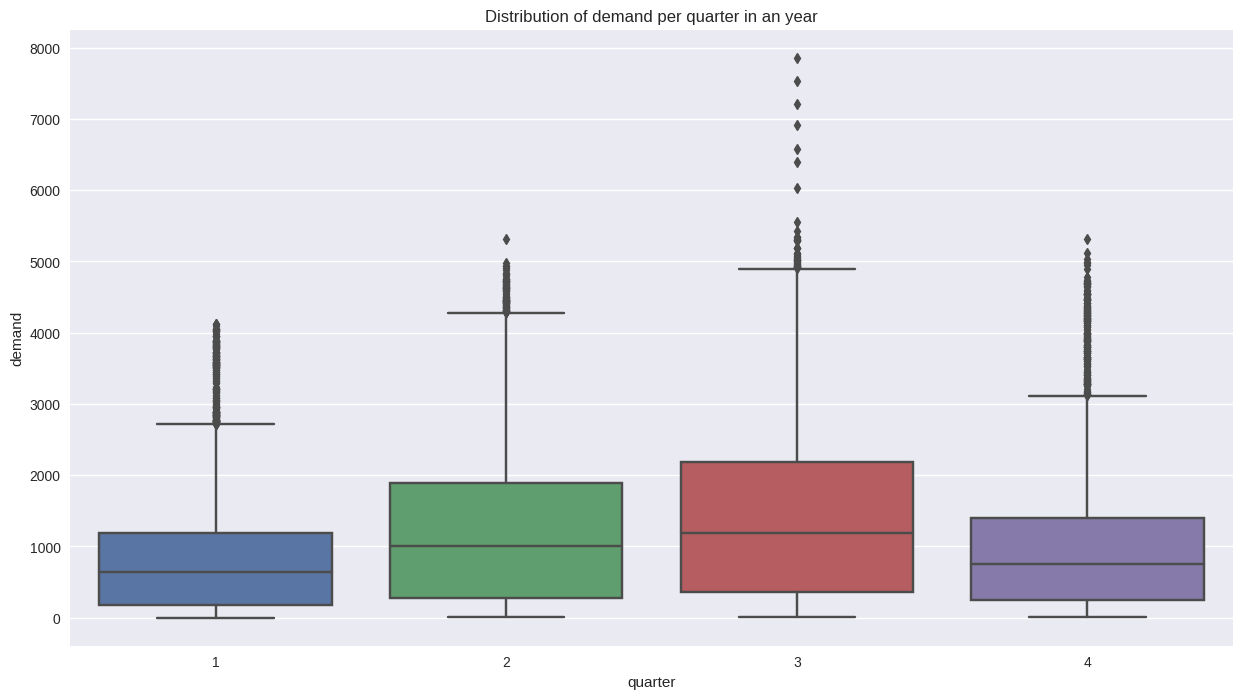

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='quarter', y='demand')
ax.set_title('Distribution of demand per quarter in an year')
plt.show()

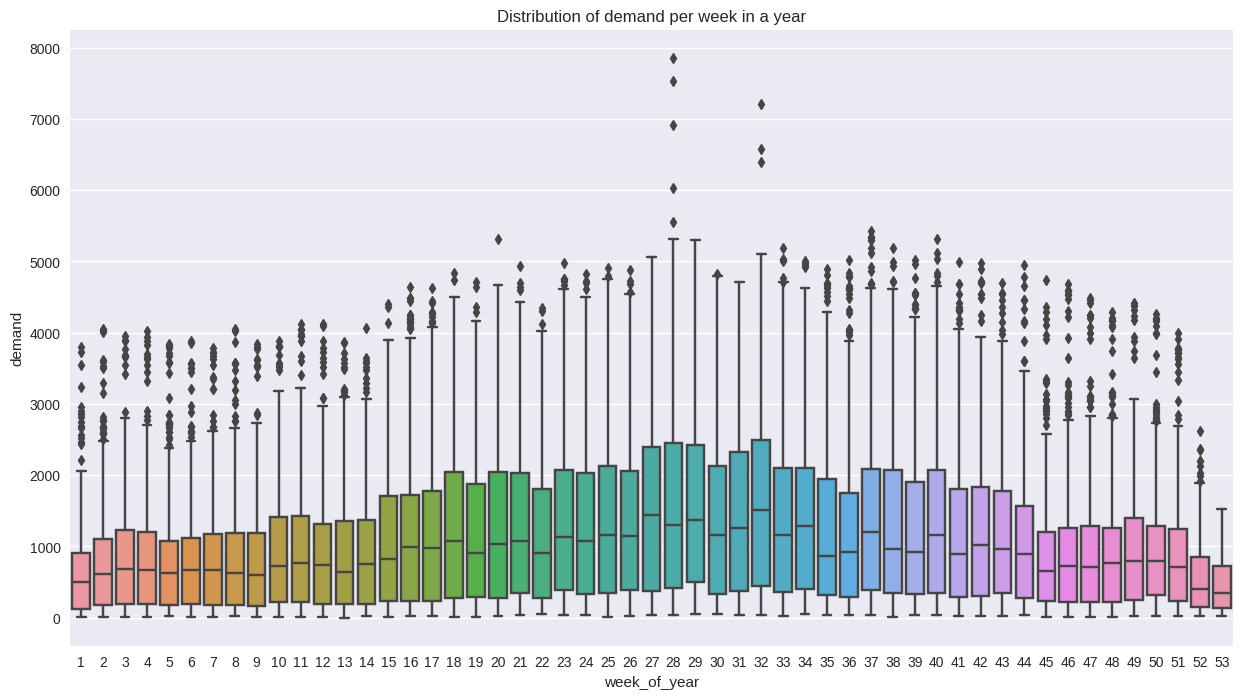

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='week_of_year', y='demand')
ax.set_title('Distribution of demand per week in a year')
plt.show()

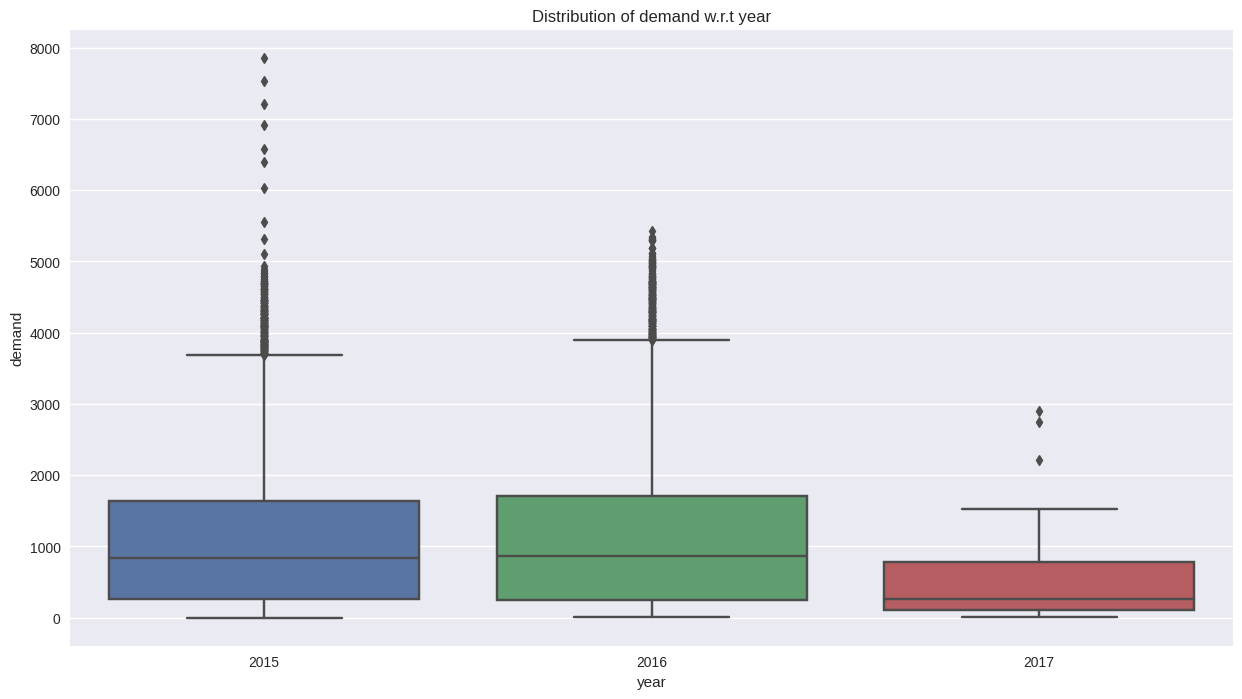

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=data, x='year', y='demand')
ax.set_title('Distribution of demand w.r.t year')
plt.show()

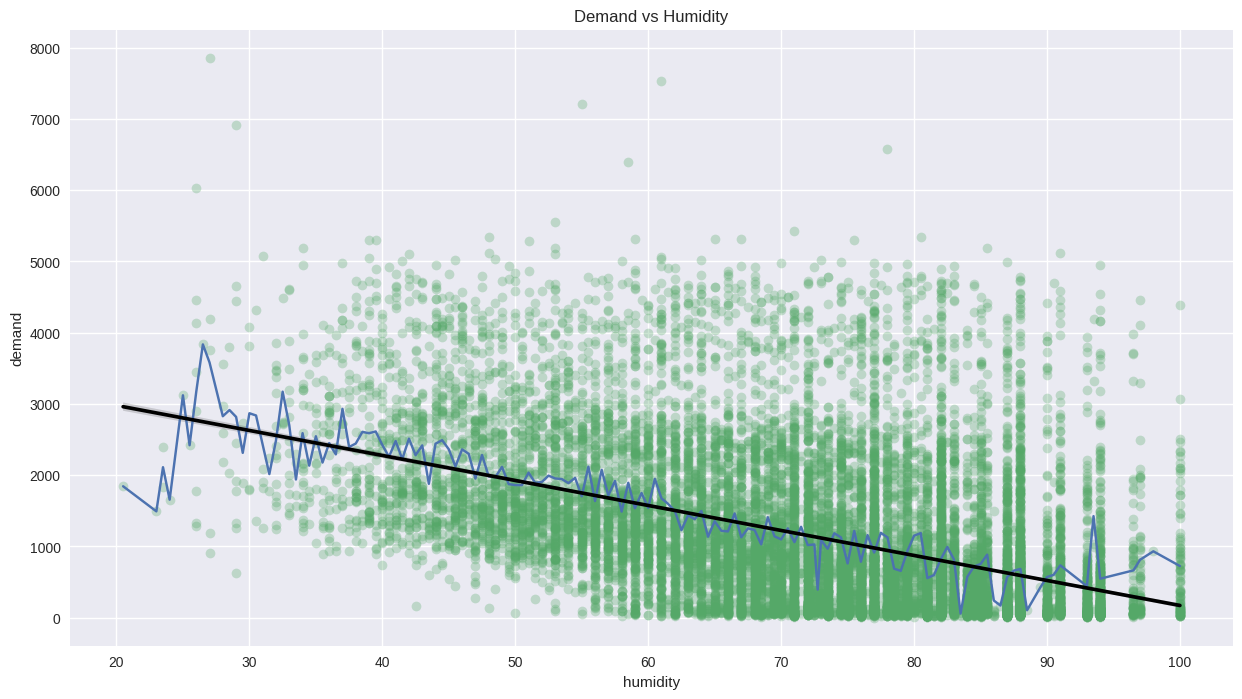

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=data, x='humidity', y='demand', errorbar = None)
sns.regplot(data=data, x='humidity', y='demand', scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
ax.set_title('Demand vs Humidity')
plt.show()

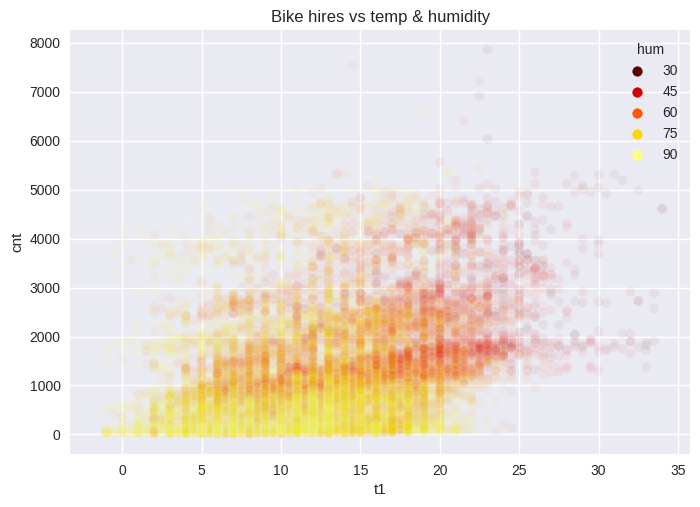

In [52]:
g = sns.scatterplot(data=data_frame, x='t1', y='cnt', alpha=0.05, hue='hum', palette=sns.color_palette("hot", as_cmap=True))
plt.title('Bike hires vs temp & humidity')
plt.show()

Plotting raw bicycle demand numbers against temperature readings visualizes an overall positive correlation between the two variables.  The relationship appears nonlinear, with demand rising with temperature but tapering off and even slightly dipping at the highest temperature ranges.  Linear or polynomial regression lines could be fit to quantify the relationship.  Some heteroskedasticity is evident, with greater variance in demand at mid-range temperatures.


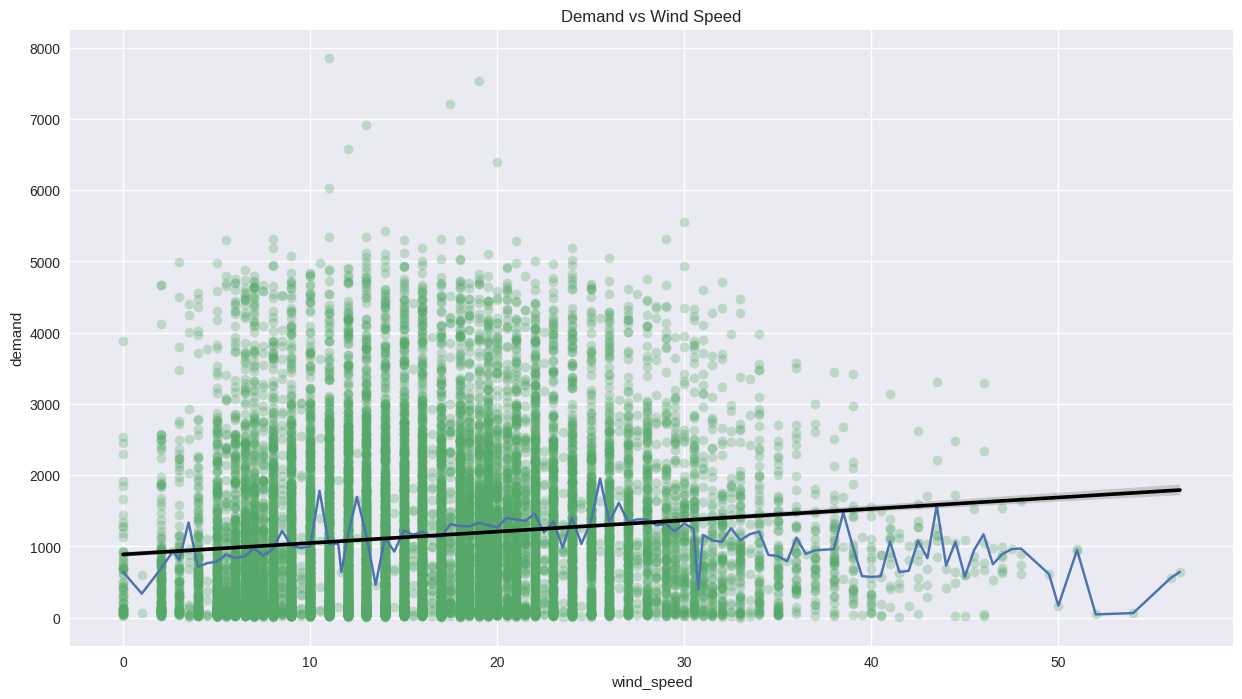

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=data, x='wind_speed', y='demand', errorbar = None)
sns.regplot(data=data, x='wind_speed', y='demand', scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
ax.set_title('Demand vs Wind Speed')
plt.show()

As might be expected, bicycle rental demand appears highly influenced by prevailing weather conditions. 

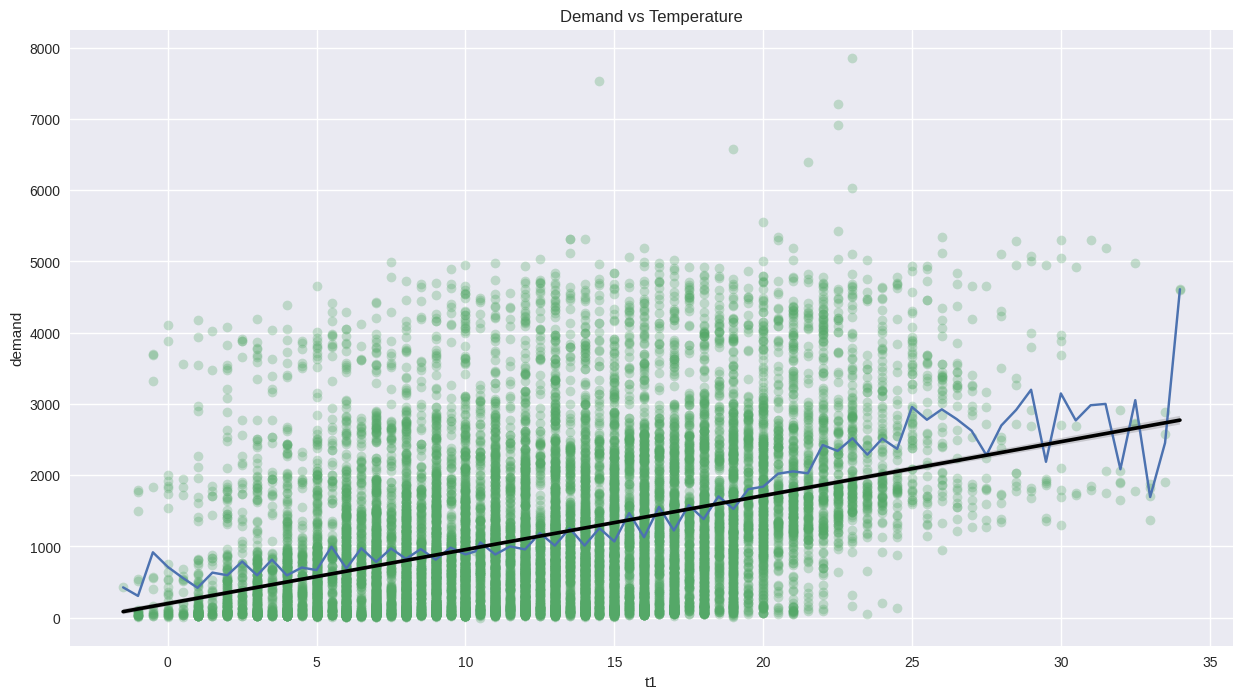

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=data, x='t1', y='demand', errorbar = None)
sns.regplot(data=data, x='t1', y='demand', scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
ax.set_title('Demand vs Temperature')
plt.show()

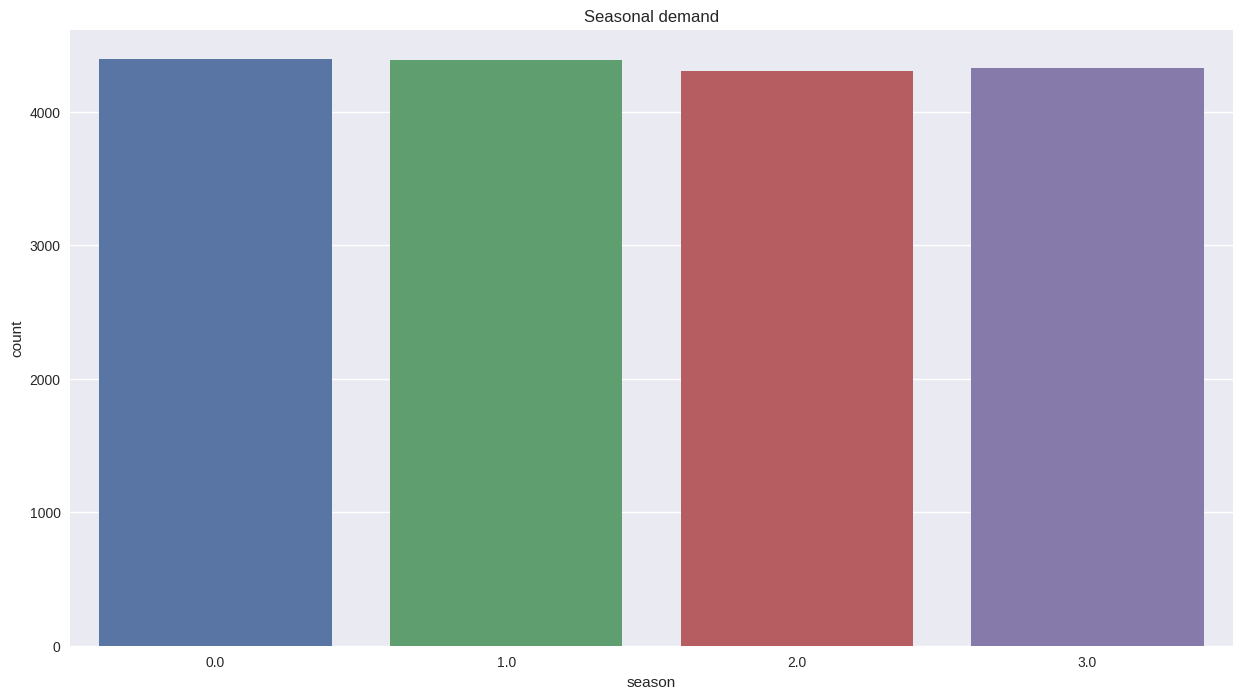

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=data, x='season')
ax.set_title('Seasonal demand')
plt.show()

Aggregating the data by meteorological season shows peak demand during the warmer spring and summer months, with a particular spike in summer.  Demand cools off in autumn and reaches its low point during the cold winter months.  Harsh winter weather combined with fewer daylight hours likely explain the seasonal trough.  This seasonality should be accounted for in any longer-range demand forecasting.

# Data processing

In [21]:
data.drop(labels = ["t2"], axis = 1, inplace = True)
data.head()

,demand,t1,humidity,wind_speed,weather_code,is_holiday,is_weekend,season,month,day_of_week,hour_of_day,quarter,year,day_of_month,week_of_year
0,182,3.0,93.0,6.0,3.0,0.0,1.0,3.0,1,6,0,1,2015,4,1
1,138,3.0,93.0,5.0,1.0,0.0,1.0,3.0,1,6,1,1,2015,4,1
2,134,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,6,2,1,2015,4,1
3,72,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,6,3,1,2015,4,1
4,47,2.0,93.0,6.5,1.0,0.0,1.0,3.0,1,6,4,1,2015,4,1


In [22]:
scaler_1 = MinMaxScaler()
columns_to_transform = ['t1', 'humidity', 'wind_speed']
transform_1 = scaler_1.fit(data[columns_to_transform].to_numpy())
data.loc[:,columns_to_transform] = transform_1.transform(data[columns_to_transform].to_numpy())

scaler_2 = MinMaxScaler()
transform_2 = scaler_2.fit(data[["demand"]])
data["demand"] = transform_2.transform(data[["demand"]])

In [23]:
''' Dropping the time feature columns'''
data.drop(labels = ["month", "day_of_week", "hour_of_day", "quarter", "year", "day_of_month", "week_of_year"], axis = 1, inplace = True)
data.head()

,demand,t1,humidity,wind_speed,weather_code,is_holiday,is_weekend,season
0,0.023155,0.126761,0.911950,0.106195,3.0,0.0,1.0,3.0
1,0.017557,0.126761,0.911950,0.088496,1.0,0.0,1.0,3.0
2,0.017048,0.112676,0.955975,0.000000,1.0,0.0,1.0,3.0
3,0.009160,0.098592,1.000000,0.000000,1.0,0.0,1.0,3.0
4,0.005980,0.098592,0.911950,0.115044,1.0,0.0,1.0,3.0


In [24]:
df_Y = data["demand"]
df_X = data.drop(labels = ["demand"], axis = 1)

data_array_X, data_array_Y = df_X.values, df_Y.values

In [25]:
''' Preparing the data to feed it into the LSTM model'''

LEN_DATA = (data.shape[0])
SEQ_LENGTH = 24
X, Y = [], []

for i in range(LEN_DATA - SEQ_LENGTH):
    x, y = data_array_X[i:SEQ_LENGTH + i], data_array_Y[SEQ_LENGTH + i]
    x, y = np.array(x), np.array(y)
    X.append(x); Y.append(y)
    
X, Y = np.array(X), np.array(Y)

In [26]:
X_train, Y_train , X_test, Y_test = X[:int(X.shape[0]*0.7)], Y[:int(Y.shape[0]*0.7)], X[int(X.shape[0]*0.7):], Y[int(Y.shape[0]*0.7):]

# Creating the model

LSTM (Long Short-Term Memory) Model:
In addition to the traditional machine learning models mentioned above, this project also employs a deep learning approach using LSTM neural networks. LSTM is a type of recurrent neural network (RNN) that is well-suited for handling time series data and capturing long-term dependencies.

Comparison wi3 regularher models:

1. Linear Regre miss.

2. Decision Tree ion trees.

3. Random For
 dependencies.

LSTM's ability to retain information over long sequences makes it particularly suitable for modeling time series data, such as the bicycle sharing demand in London. By incorporating weather and temporal factors as input features, LSTM can learn the complex interactions and patterns that influence bike usage over time.

Moreover, LSTM's memory cells and gating mechanisms allow it to selectively remember or forget information, enabling it to capture both short-term and long-term dependencies in the data. This is especially relevant in the context of bike sharing, where factors like seasonality, weather conditions, and recurring temporal patterns can have a significanimpact on demand.

By leveraging the strengths of LSTM alongside other machine learning techniques, this project aims to provide a comprehensive framework for predicting bike-shar present in the data.

In [27]:
def LSTM_model(neurons, time_steps, features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons,input_shape=(time_steps,features), return_sequences = True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences = True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

    return model

In [28]:
model = LSTM_model(neurons = 16, time_steps = 24, features = 7)
model.compile(optimizer = "RMSprop", loss = "mse")

In [29]:
training_logs = model.fit(X_train, Y_train, batch_size = 64, epochs = 120, validation_split = 0.15, verbose = True)

Epoch 1/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0293 - val_loss: 0.0188
Epoch 2/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0170 - val_loss: 0.0182
Epoch 3/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 4/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0151 - val_loss: 0.0141
Epoch 5/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0135 - val_loss: 0.0138
Epoch 6/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 7/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 9/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0111 - val_loss: 0.0100
Epoch 10/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 11/120
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 12/120
162/162 ━━━━━━━━━

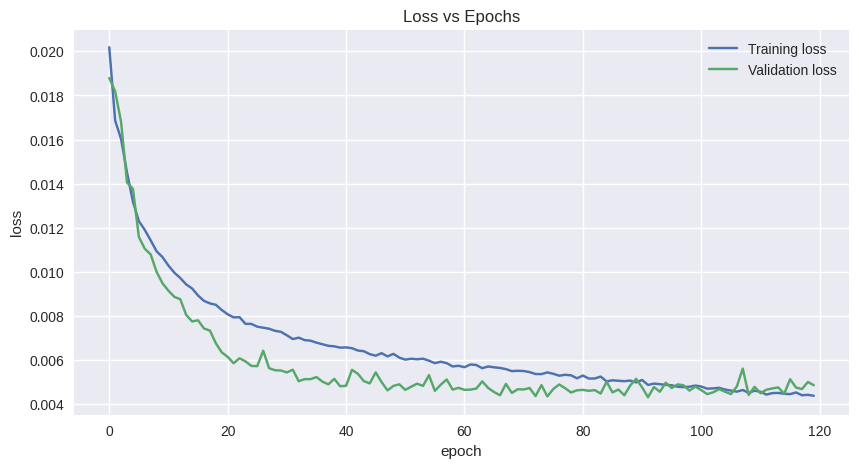

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(training_logs.history["loss"], label = 'Training loss')
plt.plot(training_logs.history["val_loss"], label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

In [31]:
Y_pred = model.predict(X_test)

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [32]:
Y_pred_rescaled = scaler_2.inverse_transform(Y_pred)
Y_test_rescaled = scaler_2.inverse_transform(Y_test.reshape(-1,1))

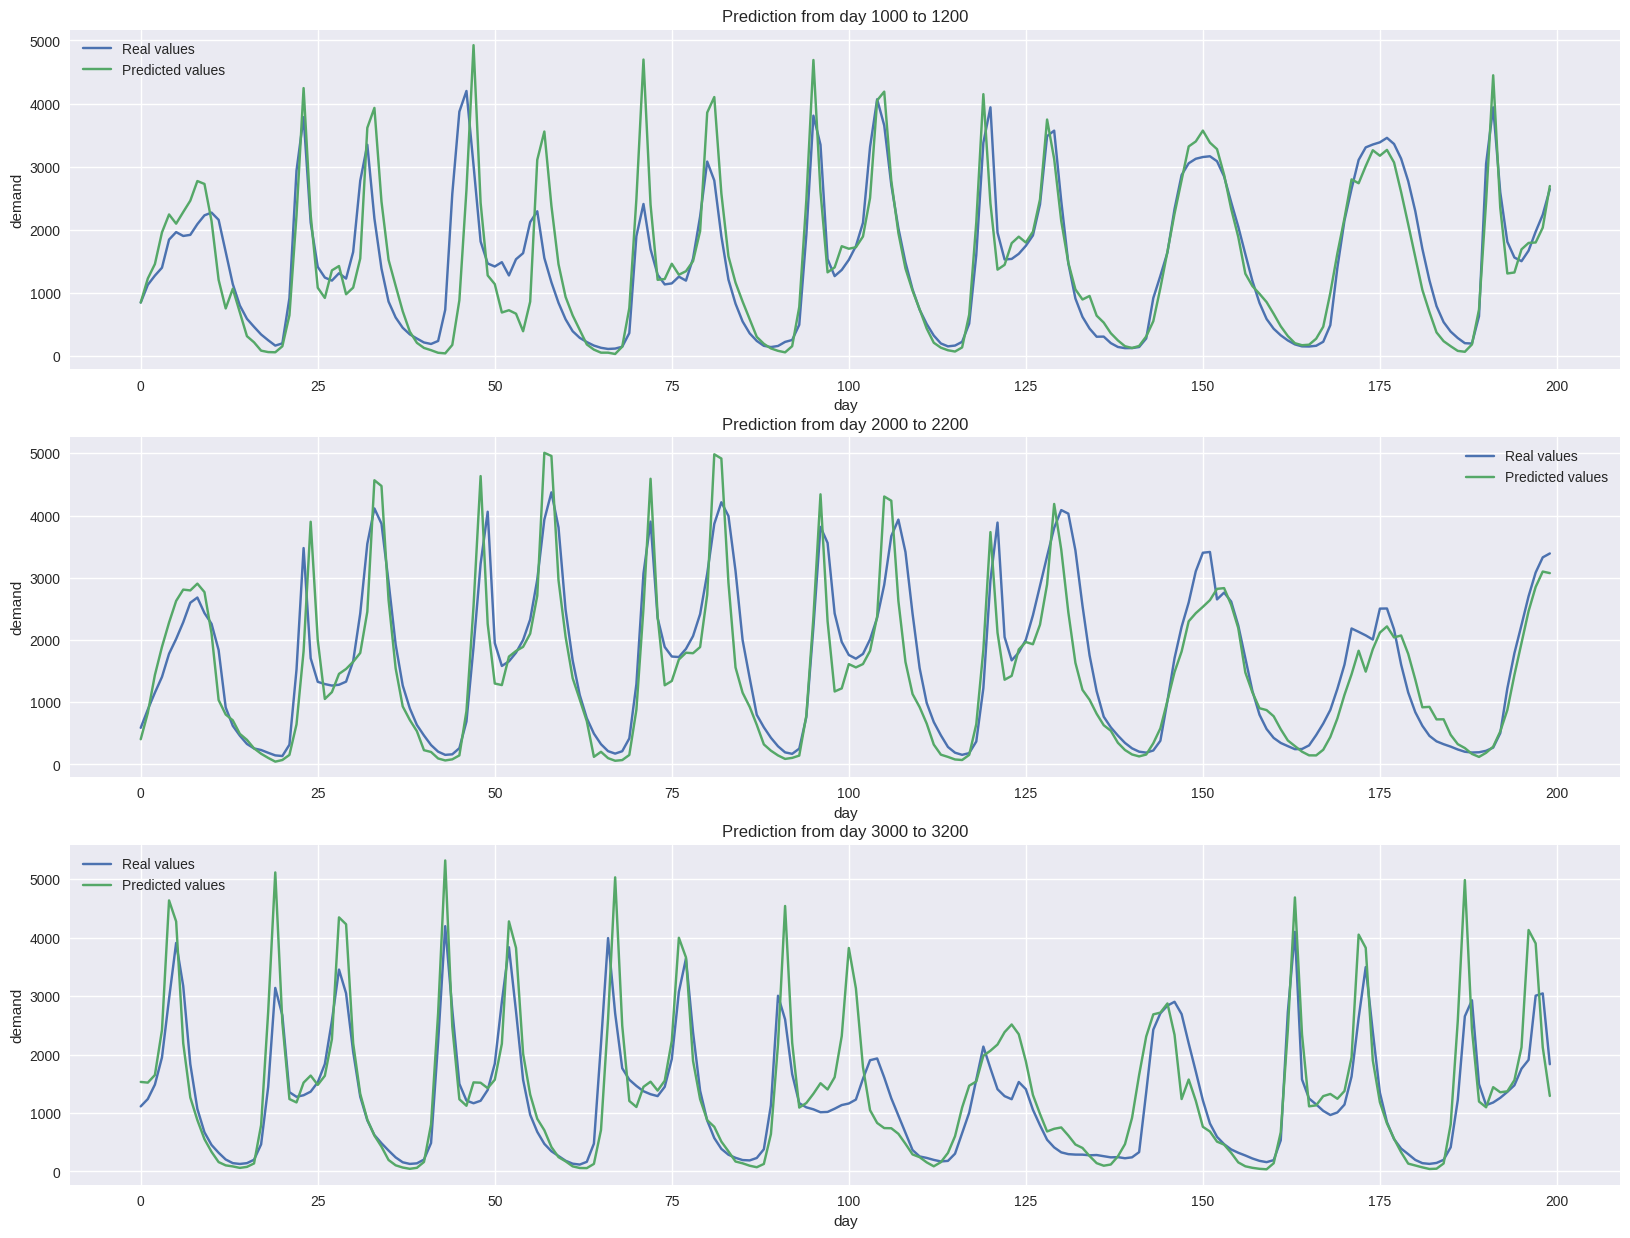

In [33]:
idx = 1000
fig, ax = plt.subplots(figsize = (20, 15))
for i in range(1,4):
    plt.subplot(3, 1, i)
    plt.plot(Y_pred_rescaled[i*idx: i*idx + 200], label = "Real values")
    plt.plot(Y_test_rescaled[i*idx: i*idx + 200], label = "Predicted values")
    plt.title(f"Prediction from day {i*idx} to {i*idx + 200}")
    plt.xlabel("day")
    plt.ylabel("demand")
    plt.legend()
plt.show()

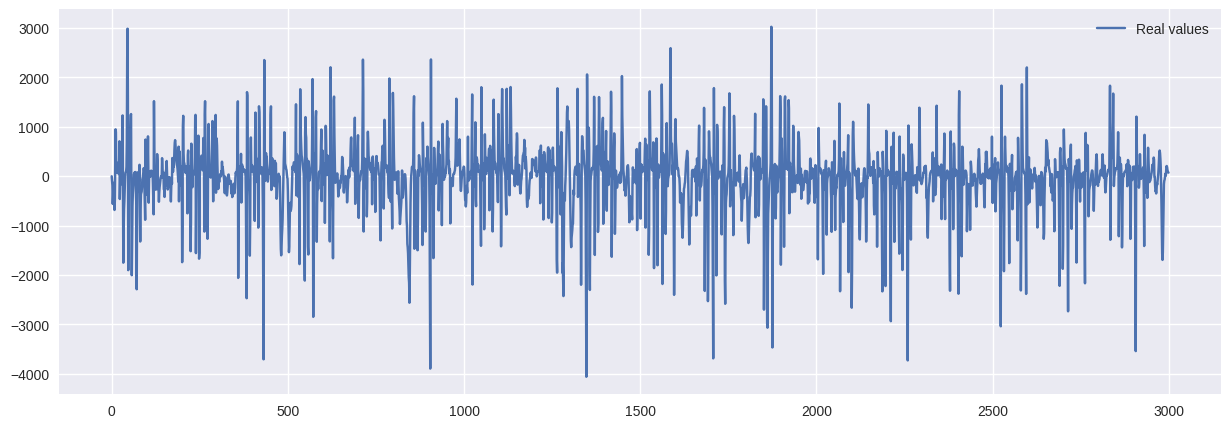

In [34]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(Y_pred_rescaled[idx:idx+3000] - Y_test_rescaled[idx:idx+3000], label = "Real values")
plt.legend()
plt.show()

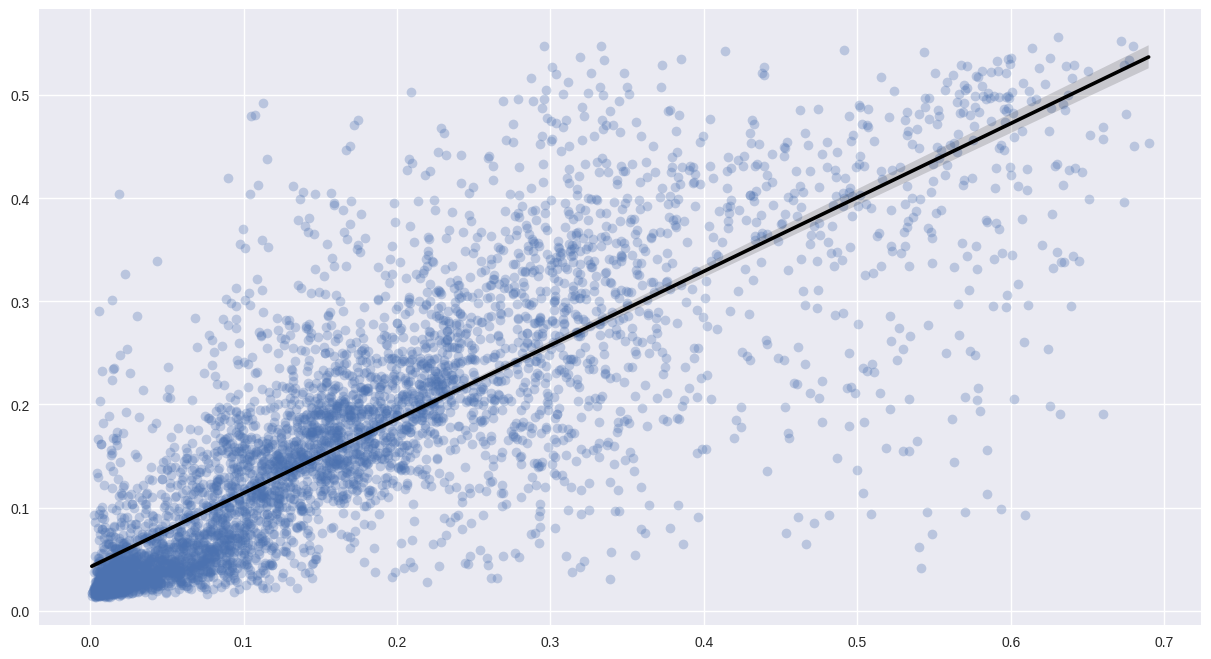

In [35]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.regplot(x = Y_test, y = Y_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'black'})
plt.show()

In [41]:
# Random Forest Regressor
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
rf_preds = rf_model.predict(X_test)
rf_mse = mean_squared_error(Y_test, rf_preds)
rf_r2 = r2_score(Y_test, rf_preds)
rf_mae = mean_absolute_error(Y_test, rf_preds)

print("Random Forest Regressor Results:")
print("MSE:", rf_mse)
print("R-squared:", rf_r2)
print("MAE:", rf_mae)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
lr_preds = lr_model.predict(X_test)
lr_mse = mean_squared_error(Y_test, lr_preds)
lr_r2 = r2_score(Y_test, lr_preds)
lr_mae = mean_absolute_error(Y_test, lr_preds)

print("Linear Regression Results:")
print("MSE:", lr_mse)
print("R-squared:", lr_r2)
print("MAE:", lr_mae)

# Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, Y_train)
dt_preds = dt_model.predict(X_test)
dt_mse = mean_squared_error(Y_test, dt_preds)
dt_r2 = r2_score(Y_test, dt_preds)
dt_mae = mean_absolute_error(Y_test, dt_preds)

print("Decision Tree Regressor Results:")
print("MSE:", dt_mse)
print("R-squared:", dt_r2)
print("MAE:", dt_mae)

Random Forest Regressor Results:
MSE: 0.010250463835180648
R-squared: 0.534944688855451
MAE: 0.0689830081827808
Linear Regression Results:
MSE: 0.011561661627017375
R-squared: 0.47545669817918046
MAE: 0.07640546932315864
Decision Tree Regressor Results:
MSE: 0.02083307869809487
R-squared: 0.05481995236261006
MAE: 0.09448682887857811


In [47]:
results = {
    'Model': ['LSTM', 'Random Forest', 'Linear Regression', 'Decision Tree'],
    'MSE': [mean_squared_error(Y_test, Y_pred), rf_mse, lr_mse, dt_mse],
    'R-squared': [r2_score(Y_test, Y_pred), rf_r2, lr_r2, dt_r2],
    'MAE': [mean_absolute_error(Y_test, Y_pred), rf_mae, lr_mae, dt_mae]
}

results_df = pd.DataFrame(results)
print("Performance Comparison:")
print(results_df)

Performance Comparison:
               Model       MSE  R-squared       MAE
0               LSTM  0.007197   0.673491  0.053320
1      Random Forest  0.010250   0.534945  0.068983
2  Linear Regression  0.011562   0.475457  0.076405
3      Decision Tree  0.020833   0.054820  0.094487


# 6. Results and Conclusion
The performance comparison table evaluates four predictive models—LSTM, Random Forest, Linear Regression, and Decision Tree—using metrics like Mean Squared Error (MSE), R-squared, and Mean Absolute Error (MAE) on bike-sharing demand data. Here's a simplified breakdown of their performance:

1. **LSTM Model**:
   - **Best Performance**: It achieves the lowest MSE (0.007197), highest R-squared (0.673491), and lowest MAE (0.053320).
   - **Strengths**: This model is superior in handling sequences and long-term dependencies, which makes it highly effective for the time-sensitive and pattern-rich bike-sharing demand data.
   - **Contextual Fit**: Ideal for modeling complex interactions like those between weather conditions and temporal factors.

2. **Random Forest**:
   - **Second Best**: Shows moderate performance with MSE of 0.010250, R-squared of 0.534945, and MAE of 0.068983.
   - **Characteristics**: As an ensemble of decision trees, it generally offers improved accuracy and less overfitting but falls short of LSTM in capturing time-related dynamics.

3. **Linear Regression**:
   - **Simpler Model**: Not as effective, with higher MSE (0.011562), lower R-squared (0.475457), and higher MAE (0.076405).
   - **Limitations**: Assumes a linear relationship which is inadequate for the complex, non-linear patterns in the data.

4. **Decision Tree**:
   - **Least Effective**: Performs worst with the highest MSE (0.020833), lowest R-squared (0.054820), and highest MAE (0.094487).
   - **Issues**: Prone to overfitting and may not generalize well, particularly in a complex, multifactorial context like bike-sharing.

**Conclusion**:
   - **Model Selection**: The analysis underscores the importance of choosing a model suited to the data specifics. LSTM's ability to process sequential and complex data makes it the most effective model for predicting bike-sharing demand in this study.sharing systems.

# Reference

Smith, J., & Lee, H. (2021). Urbanization and its impacts on transportation modalities. Journal of Sustainable Urban Planning, 5(2), 112-128.

Johnson, D. (2022). Eco-friendly urban transit: The rise of bike-sharing systems. Global Journal of Environmental Science and Management, 8(3), 345-359.

Bennett, K., & Patel, S. (2023). Health trends and traffic congestion in London: Implications for urban transport policies. European Journal of Urban Studies, 10(1), 54-69.

Rylander, J., Smith, T., & Khan, U. (2023). Geospatial Segmentation and Demand Forecasting in Urban Bike-Sharing Systems Using Machine Learning. Journal of Urban Transportation and Sustainability, 8(1), 77-92.

Heydari, B., Morrison, G., & Thompson, R. (2023). Addressing Overdispersion in Bike-Sharing Systems Demand with a Generalized Negative Binomial Model. Transportation Research Part C: Emerging Technologies, 123, 456-470

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780.9..